In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as pp

parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)

from utils.db_utils import df_from_snowflake
from scipy.optimize import curve_fit
from utils.curve_fitting import *

In [2]:
with open ('query.sql', 'r') as sql_file:
    data = df_from_snowflake(sql_file.read())

In [3]:
data['BIDDING_STRATEGY_TYPE'].fillna('No_Strat',inplace=True)
data.head()

,MKT_DATE,MKT_ACCOUNT_ID,ID,BID_STRATEGY_ID,BIDDING_STRATEGY_TYPE,DAY_BUDGET,RECOMMENDED_BUDGET_AMOUNT,CONVERSIONS_VALUE,MKT_COST,CONVERSIONS,ROAS
0,2023-01-23,6696175825,12269713190,9.982326e+09,Maximize Conversion Value,800,0.0,80.315584,201.65,556.780191,0.398292
1,2023-02-23,1992005247,12380728771,8.733825e+09,Target ROAS,1000,0.0,375.419706,1231.79,776.250950,0.304776
2,2023-01-23,9981067478,12242690843,9.399349e+09,Maximize Conversion Value,180,0.0,62.622133,90.92,205.078098,0.688761
3,2023-02-02,1534564229,12134462363,NaN,No_Strat,300,0.0,62.201500,313.11,201.833333,0.198657
4,2022-11-22,1534564229,10920002355,NaN,No_Strat,200,0.0,14.976667,72.64,88.666667,0.206177


In [4]:
summary = data.groupby('BIDDING_STRATEGY_TYPE')[['MKT_COST','CONVERSIONS_VALUE','DAY_BUDGET','RECOMMENDED_BUDGET_AMOUNT' ]].sum()
summary['ROAS'] = summary.CONVERSIONS_VALUE / summary.MKT_COST
summary

,MKT_COST,CONVERSIONS_VALUE,DAY_BUDGET,RECOMMENDED_BUDGET_AMOUNT,ROAS
BIDDING_STRATEGY_TYPE,,,,,
Maximize Conversion Value,22015.180000,9589.481427,29498,8200.0,0.435585
No_Strat,48737.041739,24254.007068,108418,6000.0,0.497650
Target ROAS,27713.430000,15186.685941,36667,9727.0,0.547990


In [11]:
target_roas = data[data['BIDDING_STRATEGY_TYPE']=='Target ROAS']
max_cv_value = data[data['BIDDING_STRATEGY_TYPE']=='Maximize Conversion Value']
no_strat = data[data['BIDDING_STRATEGY_TYPE']=='No_Strat']


In [12]:
target_roas.name = 'target_roas'
max_cv_value.name = 'max_cv_value'
no_strat.name = 'no_strat'

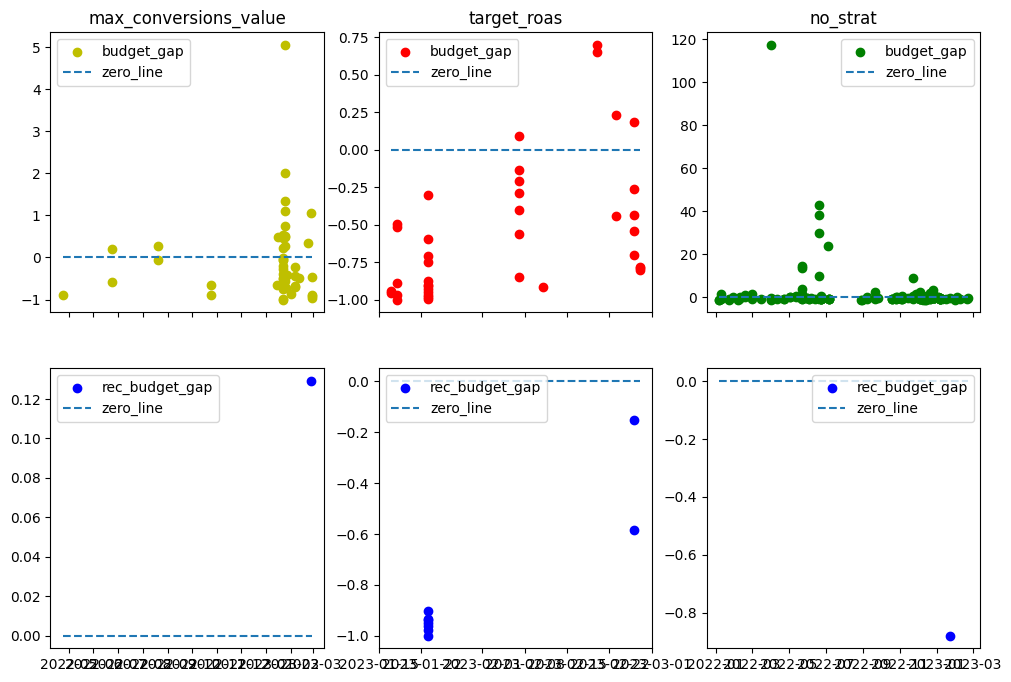

In [94]:
_, ax = pp.subplots(nrows=2, ncols=3, sharex='col', figsize=(12, 8))


ax[0,0].scatter(max_cv_value['MKT_DATE'], 
                (max_cv_value['MKT_COST']-max_cv_value['DAY_BUDGET']) / max_cv_value['DAY_BUDGET'] , 
                color='y' )
ax[0,0].hlines(y=0, ls = '--', xmin = min(max_cv_value['MKT_DATE']), xmax=max(max_cv_value['MKT_DATE']))
ax[0,0].set(title='max_conversions_value')
ax[0,0].legend(['budget_gap', 'zero_line'])

ax[1,0].scatter(max_cv_value['MKT_DATE'], 
                (max_cv_value['MKT_COST']-max_cv_value['RECOMMENDED_BUDGET_AMOUNT']) / max_cv_value['RECOMMENDED_BUDGET_AMOUNT'] , 
                color='b' )
ax[1,0].hlines(y=0, ls = '--', xmin = min(max_cv_value['MKT_DATE']), xmax=max(max_cv_value['MKT_DATE']))
ax[1,0].legend(['rec_budget_gap', 'zero_line'])

# ax[2,0].scatter(max_cv_value['MKT_DATE'], max_cv_value['ROAS'])
# ax[2,0].legend(['roas'])
# ax[2,0].set_ylim(0,2)

#
ax[0,1].scatter(target_roas['MKT_DATE'], 
                (target_roas['MKT_COST']-target_roas['DAY_BUDGET'] ) / target_roas['DAY_BUDGET'], 
                color='r' )
ax[0,1].hlines(y=0, ls = '--', xmin = min(target_roas['MKT_DATE']), xmax=max(target_roas['MKT_DATE']))
ax[0,1].set(title='target_roas')
ax[0,1].legend(['budget_gap', 'zero_line'])

ax[1,1].scatter(target_roas['MKT_DATE'], 
                (target_roas['MKT_COST']-target_roas['RECOMMENDED_BUDGET_AMOUNT']) / target_roas['RECOMMENDED_BUDGET_AMOUNT'] , 
                color='b' )
ax[1,1].hlines(y=0, ls = '--', xmin = min(target_roas['MKT_DATE']), xmax=max(target_roas['MKT_DATE']))
ax[1,1].legend(['rec_budget_gap', 'zero_line'])

# ax[2,1].scatter(target_roas['MKT_DATE'], target_roas['ROAS'])
# ax[2,1].legend(['roas'])
# ax[2,1].set_ylim(0,2)

ax[0,2].scatter(no_strat['MKT_DATE'], 
                (no_strat['MKT_COST']-no_strat['DAY_BUDGET'] ) / no_strat['DAY_BUDGET'], 
                color='g' )
ax[0,2].hlines(y=0, ls = '--', xmin = min(no_strat['MKT_DATE']), xmax=max(no_strat['MKT_DATE']))
ax[0,2].set(title='no_strat')
ax[0,2].legend(['budget_gap', 'zero_line'])

ax[1,2].scatter(no_strat['MKT_DATE'], 
                (no_strat['MKT_COST']-no_strat['RECOMMENDED_BUDGET_AMOUNT']) / no_strat['RECOMMENDED_BUDGET_AMOUNT'] , 
                color='b' )
ax[1,2].hlines(y=0, ls = '--', xmin = min(no_strat['MKT_DATE']), xmax=max(no_strat['MKT_DATE']))
ax[1,2].legend(['rec_budget_gap', 'zero_line'])

In [103]:
target_roas.head(30)

,MKT_DATE,MKT_ACCOUNT_ID,ID,BID_STRATEGY_ID,BIDDING_STRATEGY_TYPE,DAY_BUDGET,RECOMMENDED_BUDGET_AMOUNT,CONVERSIONS_VALUE,MKT_COST,CONVERSIONS,ROAS
1,2023-02-23,1992005247,12380728771,8.733825e+09,Target ROAS,1000,0.0,375.419706,1231.79,776.250950,0.304776
14,2023-01-18,9222336938,12292778376,1.016279e+10,Target ROAS,25,0.0,1.100000,12.13,10.000000,0.090684
15,2023-01-18,9222336938,12292779786,6.770911e+09,Target ROAS,40,0.0,0.000000,0.10,0.000000,0.000000
16,2023-01-18,9222336938,12292770888,1.016278e+10,Target ROAS,50,0.0,0.192500,1.73,1.500000,0.111272
26,2023-02-26,9835957247,12375992152,8.585530e+09,Target ROAS,6000,0.0,2275.850499,2767.42,1045.712223,0.822373
27,2023-02-11,6784462648,12317972629,9.557817e+09,Target ROAS,300,0.0,9.033515,25.93,48.755408,0.348381
29,2023-01-18,9222336938,12301269049,1.015570e+10,Target ROAS,120,0.0,8.606800,60.29,70.333334,0.142757
36,2023-02-07,2039872670,12184301939,8.920594e+09,Target ROAS,190,0.0,59.645266,114.21,1248.250493,0.522242
38,2023-02-27,5759076480,12290911677,7.053977e+09,Target ROAS,350,0.0,38.578232,74.97,396.794635,0.514582
40,2023-02-26,9835957247,12362773352,8.475435e+09,Target ROAS,4500,0.0,1116.417570,2558.18,357.401814,0.436411


In [97]:
no_strat[no_strat['MKT_COST']>no_strat['DAY_BUDGET']*5]

,MKT_DATE,MKT_ACCOUNT_ID,ID,BID_STRATEGY_ID,BIDDING_STRATEGY_TYPE,DAY_BUDGET,RECOMMENDED_BUDGET_AMOUNT,CONVERSIONS_VALUE,MKT_COST,CONVERSIONS,ROAS
45,2022-06-21,1534564229,11034918121,NaN,No_strat,25,0.0,366.868975,985.52,1799.821150,0.372259
53,2022-05-23,4444763644,10477523897,NaN,No_strat,15,0.0,141.059622,236.89,432.456176,0.595465
58,2022-04-02,1534564229,10359064983,NaN,No_strat,5,0.0,47.857633,591.03,298.507439,0.080973
82,2022-06-21,1534564229,11035120681,NaN,No_strat,10,0.0,151.199591,308.84,496.576022,0.489573
84,2022-05-23,4444763644,10477551086,NaN,No_strat,25,0.0,158.635682,362.08,807.291708,0.438123
107,2022-06-21,1534564229,11035125979,NaN,No_strat,50,0.0,288.374956,547.61,924.103741,0.526606
136,2022-07-05,1534564229,11025188813,NaN,No_strat,20,0.0,51.591194,492.91,649.295766,0.104667
137,2022-11-22,4444763644,10919637726,NaN,No_strat,20,0.0,74.117467,203.92,265.666667,0.363463
170,2022-06-21,1534564229,11029216686,NaN,No_strat,10,0.0,296.162368,440.59,479.738214,0.672195


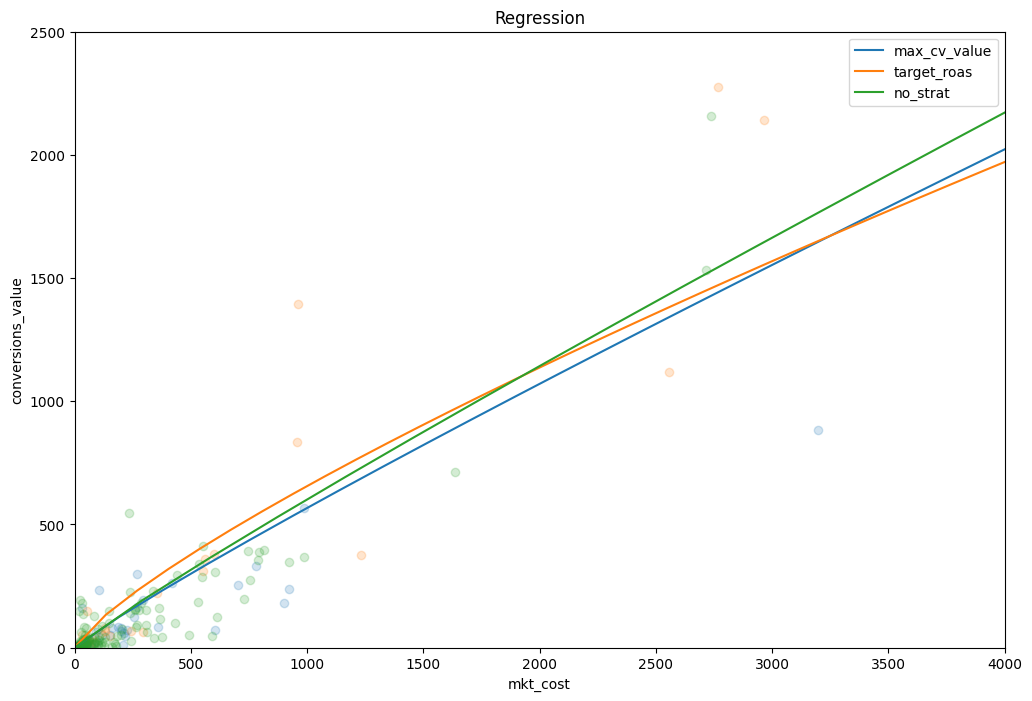

In [15]:
_, ax_2 = pp.subplots(nrows=1, ncols=1, sharex='row', figsize=(12, 8))
for n, df in enumerate([max_cv_value, target_roas,no_strat]):
    # df['MKT_COST'].apply(lambda n: np.log(n) if np.isfinite(n) else 0).values.ravel()
    # df['CONVERSIONS_VALUE'].apply(lambda n: np.log(n) if np.isfinite(n) else 0).values.ravel()

    popt, pcov = curve_fit(
            linear_2, 
            np.array(df['MKT_COST'].sort_index()), 
            np.array(df['CONVERSIONS_VALUE'].sort_index()),
            bounds=(0,1)
        )
    x_ = np.linspace(df['MKT_COST'].min(), df['MKT_COST'].max())
    pred = linear_2(x_, *popt)
    ax_2.scatter(x=np.array(df['MKT_COST'].sort_index()), 
                 y=np.array(df['CONVERSIONS_VALUE'].sort_index()), 
                 alpha=0.2)
    ax_2.plot(x_, pred, linestyle='-', label= df.name)
ax_2.set_title('Regression')
ax_2.set_xlabel('mkt_cost')
ax_2.set_ylabel('conversions_value')
ax_2.set_xlim(0,4000)
ax_2.set_ylim(0,2500)

ax_2.legend()


In [10]:
no_strat

,MKT_DATE,MKT_ACCOUNT_ID,ID,BID_STRATEGY_ID,BIDDING_STRATEGY_TYPE,DAY_BUDGET,RECOMMENDED_BUDGET_AMOUNT,CONVERSIONS_VALUE,MKT_COST,CONVERSIONS,ROAS
